#### Loading data

In [1]:
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(ape))
suppressPackageStartupMessages(library(phangorn))

saveDir <- "../environment/chimpBrain"
clustFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/no_threshold0/cluster_nwk.txt"

load(file.path(saveDir, 'yAll.RData'))
treeCons <- rowTree(yAll)
l <- length(treeCons$tip)

load(file.path(saveDir, "detNodes.RData"))

In [2]:
termFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/old/PTB162LCBC/clusters.txt"
suppressPackageStartupMessages(source("../terminus_helper.R"))
yTermThrNS <- yAll[1:l,]
groupsClust <- parseClustFile(termFile, yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepTerm(yTermThrNS, mInds, groupsClust)

#### Differentially expressed transcripts

In [10]:
dTxps <- lapply(detNodes[["Txps"]], function(txps) rownames(yAll)[txps])
sapply(dTxps, length)

[1]  3539 10133 11886

#### Genes Mapping to those transcripts

In [11]:
mapDf <- rowData(yAll)
txpGenes <- lapply(dTxps, function(txps) unique(unlist(mapDf[txps, "GENEID"])))##Genes that map to transcripts
sapply(txpGenes, length)

[1] 3236 8304 9492

#### Differentially expressed genes

In [9]:
load(file.path(saveDir, "yg.RData"))
dges <- lapply(detNodes[["Genes"]], function(genes) rownames(yg)[genes])
sapply(dges,length)

[1] 6090 8256 9354

#### Genes that are considered differentially expressed in genes but dont contain a single differentially expressed transcript

In [10]:
diffGenes <- lapply(seq_along(dges), function(i) setdiff(dges[[i]], txpGenes[[i]])) ## Txps that are missing in differential transcripts mapping to genes
sapply(diffGenes, length)
diffGenes2 <- lapply(seq_along(dges), function(i) setdiff(txpGenes[[i]], dges[[i]])) ## Txps that are missing in differential transcripts mapping to genes                    
sapply(diffGenes2, length)
# sum(mcols(y)[unlist(mcols(yg)[diffGenes[[2]],"tx_ids"]), "qvalue"] < 0.05, na.rm=T)==0 ## None of the diffGenes should contain a differential transcript

[1] 2984  787  716

[1] 130 835 854

#### Height of the nodes in treeclimbR and mehenDi

In [11]:
lapply(detNodes$`treeClimbR(N)`, function(nodes) table(node.depth(treeCons,2)[nodes]))
lapply(detNodes$mehenDi, function(nodes) table(node.depth(treeCons,2)[nodes]))

[[1]]

   1    2    3    4    5    6    7    8    9 
2698  511  177   73   29   11    5    4    1 

[[2]]

   1    2    3    4    5    6    7    8    9   10 
7415  786  285  120   46   19    9    4    1    2 

[[3]]

   1    2    3    4    5    6    7    8    9   10   11 
8105 1197  460  191   76   30   15    9    4    3    1 


[[1]]

   1    2    3    4    5    6    7    8    9   10 
2721  705  342  126   70   18   10    5    3    1 

[[2]]

   1    2    3    4    5    6    7    8    9 
7979 1387  554  196   73   33   15    6    4 

[[3]]

   1    2    3    4    5    6    7    8    9 
9272 1731  643  229   78   36   18    6    4 


#### Transcripts mapping to the features

In [3]:
j <- 1
treeDETxps <- rownames(yAll)[unlist(Descendants(treeCons, detNodes[["mehenDi"]][[j]]))]
treeClimbTxps <- rownames(yAll)[detNodes[["treeClimbR(L)"]][[j]]]

dN <- detNodes[["Terminus"]][[j]]

termTxps <- c(rownames(yTermThrNS)[dN][startsWith(rownames(yAggTermThrNS)[dN], "ENS")],
  rownames(yAggTermThrNS)[as.numeric(unlist(groupsClust[rownames(yAggTermThrNS)[dN][!startsWith(rownames(yAggTermThrNS)[dN], "ENS")]]))])

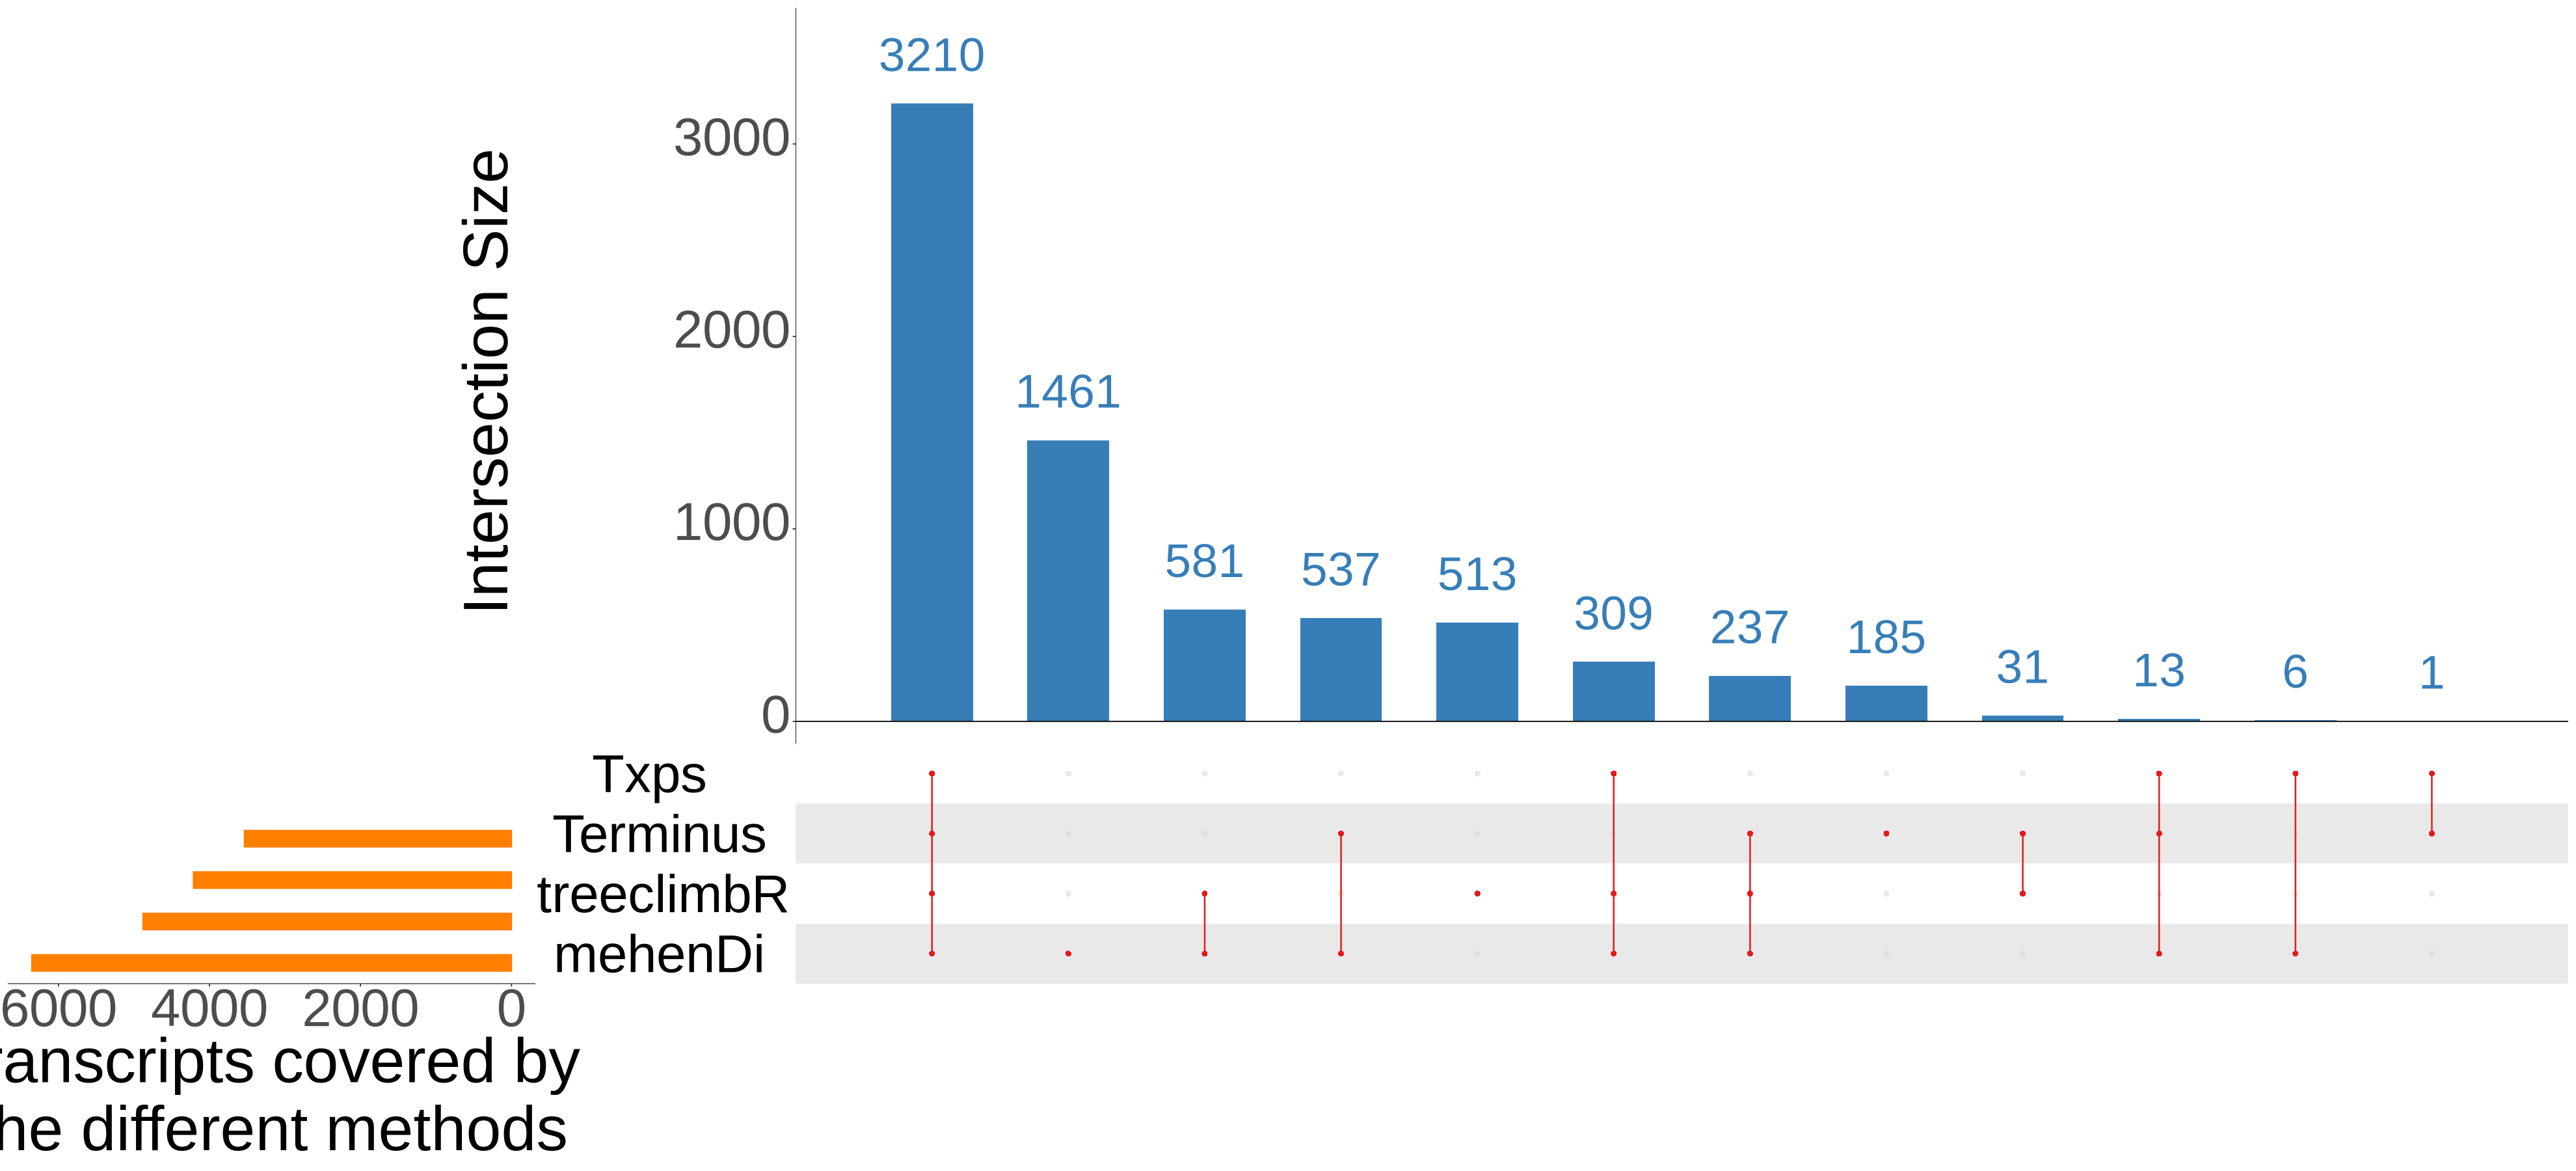

In [4]:
options(repr.plot.width=33, repr.plot.height=15)
suppressPackageStartupMessages(library(UpSetR))
txpMethods = list(Txps = rownames(yAll)[detNodes[["Txps"]][[j]]], 
                 mehenDi = treeDETxps, 
                 treeclimbR = treeClimbTxps, 
                 Terminus = termTxps
                 )
upsetData <- fromList(txpMethods)
size <- 7
upset(upsetData, order.by = "freq",
     main.bar.color = "#377eb8", 
     matrix.color = "#e41a1c",
     sets.bar.color = c("#ff7f00"),
     sets.x.label = "Transcripts covered by \nthe different methods",
     shade.alpha = 0.7, 
     mb.ratio = c(0.7,0.4),
     text.scale = c(size, size, size, size, size, size)
)

In [19]:
sapply(detNodes$`treeClimbR(N)`,length)
sapply(detNodes$mehenDi,length)

[1]  3509  8687 10091

[1]  4001 10247 12017

#### Genes mapping to the mehenDi nodes and their number

In [21]:
mehenDiNodes <- detNodes[["mehenDi"]]
genesmehenDi <- lapply(mehenDiNodes, function(nodes) {
    lapply(Descendants(treeCons,nodes), function(desc) unique(unlist(mapDf[treeCons$tip[desc],"GENEID"])))})
sapply(genesmehenDi, function(genes) length(unique(unlist(genes)))) ## Number of genes mapping to treeDE nodes
sapply(genesmehenDi, function(nodes) table(sapply(nodes,length))) ## Distribution of number of genes and nodes

[1] 3714 8661 9904

[[1]]

   1    2 
3943   58 

[[2]]

    1     2     3 
10106   140     1 

[[3]]

    1     2     3 
11842   174     1 


#### Genes that map only to mehenDi but are neither DE or covered by differential transcripts

In [22]:
### Nodes that dont cotain a DET
ll <- lapply(seq_along(mehenDiNodes), function(i) {
    desc <- Descendants(treeCons, mehenDiNodes[[i]])
    which(sapply(desc, function(txps) sum(txps %in% detNodes[["Txps"]][[i]]) == 0))
})

### Nodes that DO NOT contain a single DE gene
sapply(ll, length)
nodesNotDE <- lapply(seq_along(ll), function(i) {
    genesL <- genesmehenDi[[i]][ll[[i]]]
    ll[[i]][sapply(genesL, function(genes) sum(genes %in% dges[[i]]) == 0)]
})
sapply(nodesNotDE, length)

[1] 485 318 365

[1] 31 59 76

#### Genes belonging to mehenDi nodes that intersect with differentially expressed genes which do not a single differentially expressed transcript

In [23]:
mehenDiDegNodes <- lapply(seq_along(genesmehenDi), function(i) {
    which(sapply(genesmehenDi[[i]], function(gs) sum(gs %in% diffGenes[[i]]) > 0))
})
sapply(mehenDiDegNodes,length)
save(mehenDiDegNodes, file=file.path(saveDir, "mehenDiDegNodes.RData"))

[1] 407 194 213

##### Distribution of genes mapped to by such nodes in mehenDi

In [24]:
sapply(seq_along(mehenDiDegNodes), function(i) {
    table(sapply(genesmehenDi[[i]][mehenDiDegNodes[[i]]], function(gs) length(gs)))
})

1,375,184,194
2,32,10,19


In [6]:
library(ggplot2)
library(ComplexUpset)


Attaching package: ‘ComplexUpset’


The following object is masked from ‘package:UpSetR’:

    upset




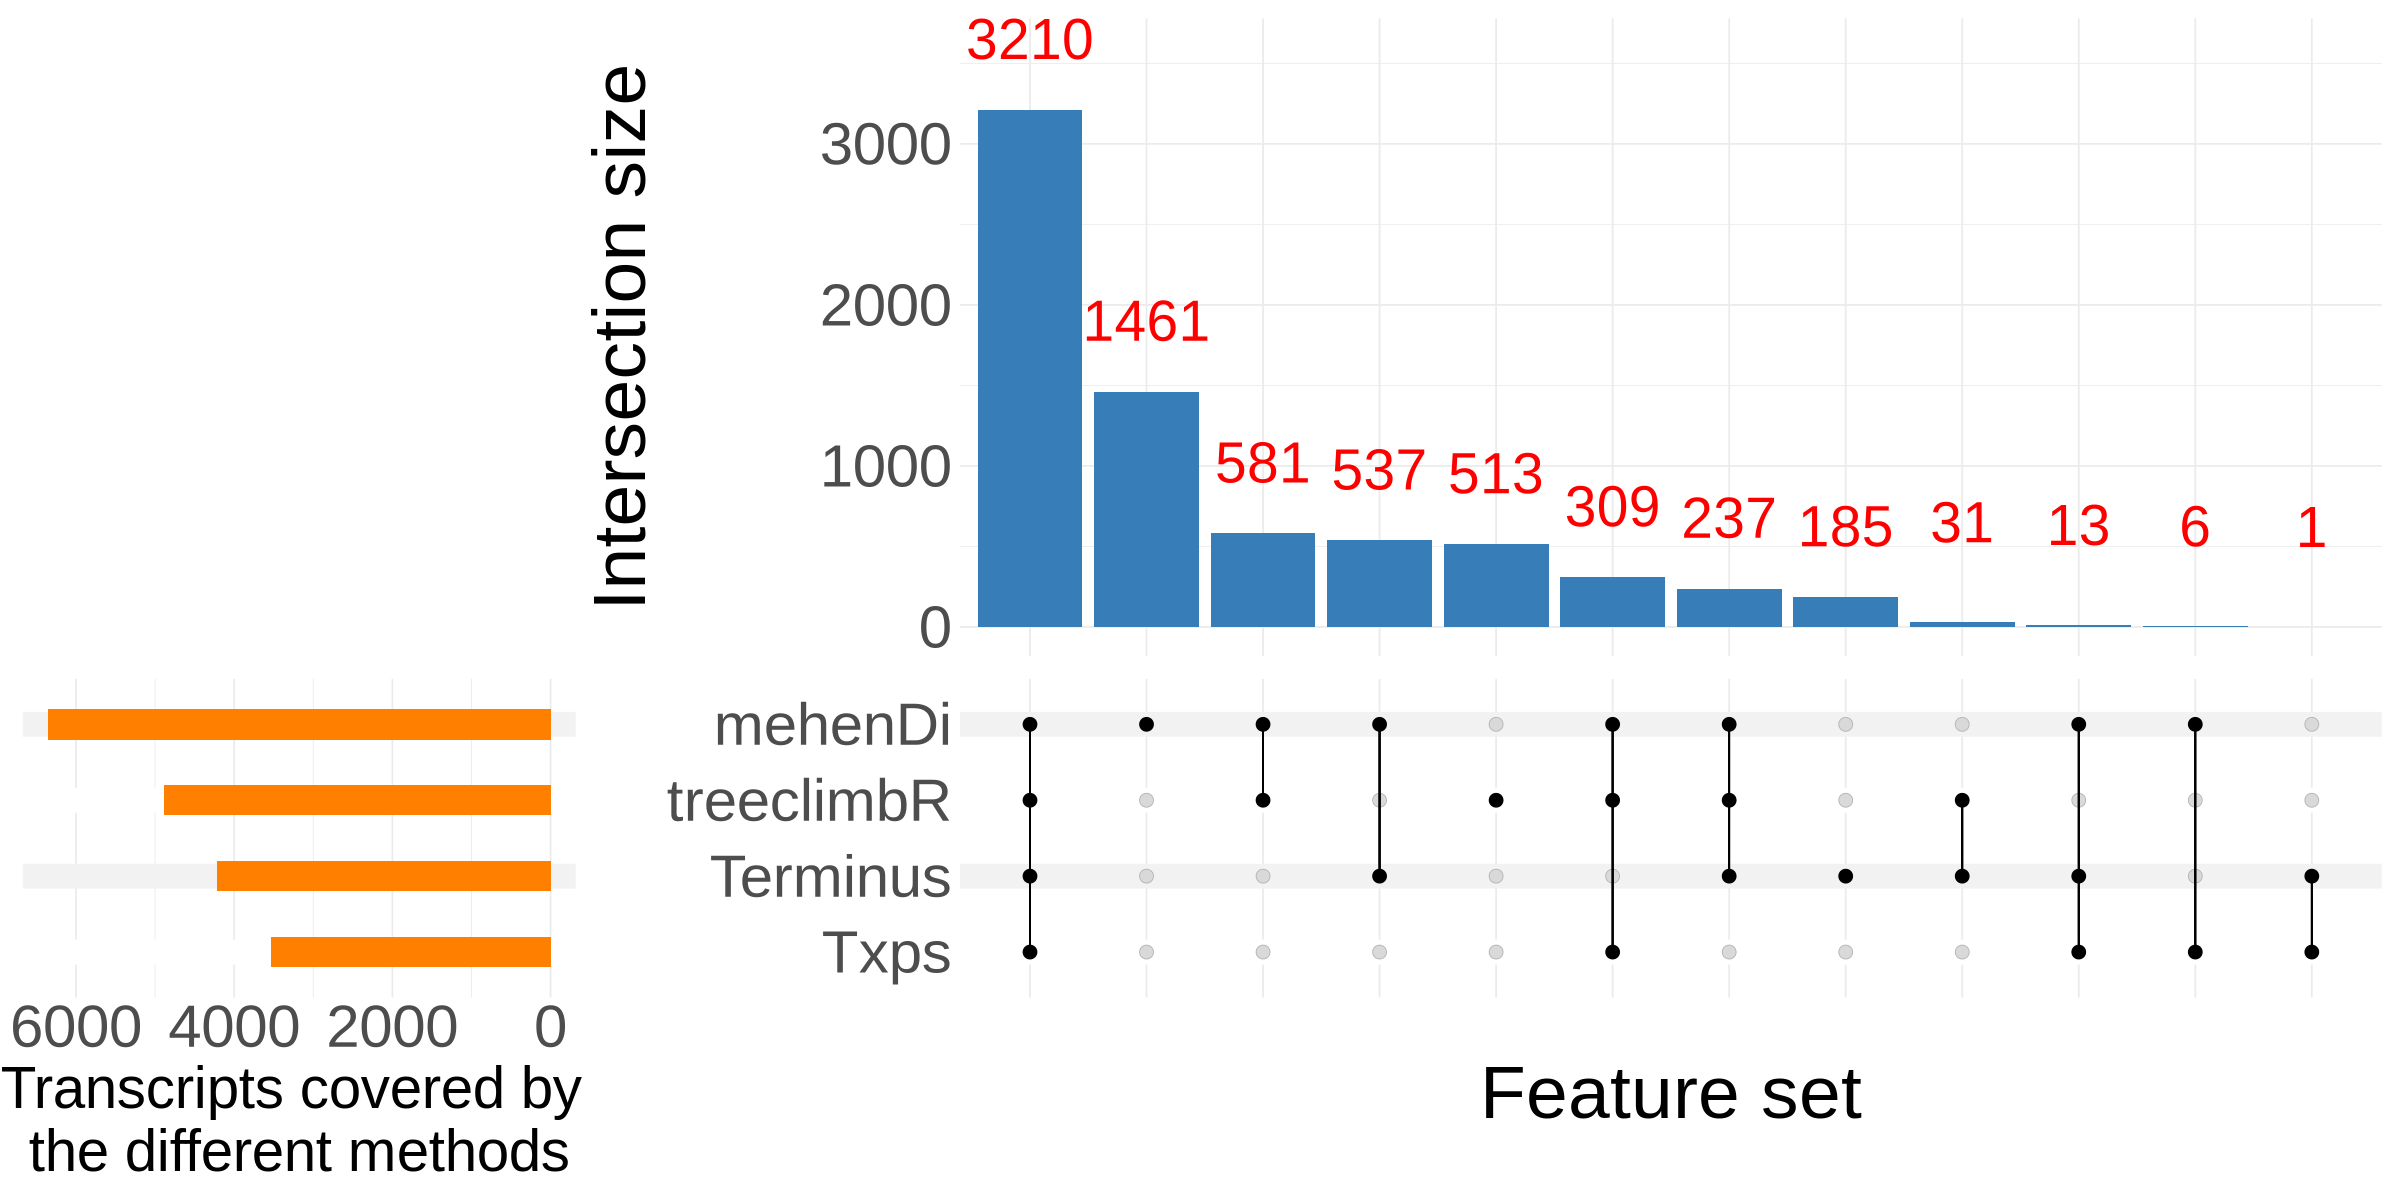

In [75]:
options(repr.plot.width=20, repr.plot.height=10)
size = get_size_mode('exclusive_intersection')
ComplexUpset::upset(upsetData, colnames(upsetData), name='Feature set', width_ratio=0.28, min_size=1,
                       base_annotations=list('Intersection size'= intersection_size(
                                               text=list(size=12, 
                                                         vjust=-2),
                                                 mapping=aes(fill="bars_color"),
                                                text_mapping=aes(   
                                                    y=ifelse(!!size> 150, !!size-180, !!size-1)
                                                ),
                                               text_colors=c(on_bar='red',on_background='red')
                                               ) +
                                             ylim(c(0,3600)) + xlab("Transcripts covered") +
                     scale_fill_manual(values=c('bars_color'="#377eb8"), guide='none')
                                             ),
                       themes=upset_default_themes(text=element_text(size=45)),
                        set_sizes=upset_set_size(geom = geom_bar(
                            width=0.4,
                            fill = "#ff7f00"
                        )) +
                             theme(axis.title.x=element_text(size=35)) +
                            ylab('Transcripts covered by \nthe different methods')
                   )


In [34]:
    base_annotations=list(
        'Intersection size'=intersection_size(
            text_mapping=aes(
                label=paste0(
                    !!upset_text_percentage(),
                    '\n(', !!size, ')'
                ),
                colour=ifelse(!!size > 50, 'on_bar', 'on_background'),
                y=ifelse(!!size > 50, !!size - 100, !!size)
            )
        )
    )

,Txps,trenDi,treeclimbR,Terminus
,<int>,<int>,<int>,<int>
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
5,1,1,1,1
6,1,1,1,1


In [24]:
size

exclusive_intersection_size